In [17]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [13]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
M = Base.classes.measurement
S = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
first_row = session.query(M).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1de8d709f70>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [10]:
last_date = session.query(M.date).order_by(M.date.desc()).first()
last_date[0]

'2017-08-23'

In [11]:
# # Calculate the date one year from the last date in data set.
# # Capture last date as list of integers in variable "date"


## Commented out - this captures the correct date, but when applied
## the first value returned in the dataframe is 08-24-2016
## May come back later to investigate

# time_data = last_date[0]
# format_data = "%Y-%m-%d"
# date = dt.datetime.strptime(time_data, format_data)
# date
# year_ago = date - dt.timedelta(days=365)

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
last_year = session.query(M.date,M.prcp).filter(M.date >= year_ago).statement
year_ago

datetime.date(2016, 8, 23)

In [15]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.read_sql(last_year, session.bind).set_index('date')

# Sort the dataframe by date
prcp_df2 = prcp_df.sort_index()
prcp_df2 = prcp_df2.rename(columns={'prcp':'precipitation'})
prcp_df2

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


Text(0, 0.5, 'Inches')

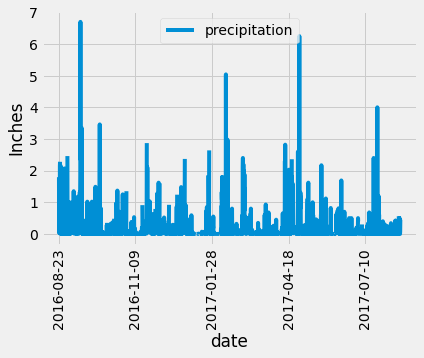

In [18]:
# Plot the data
prcp_df2.plot(rot=90)
plt.ylabel('Inches')


In [20]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df2[['precipitation']].describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [21]:
# Design a query to calculate the total number stations in the dataset

# first, review table headers
first_row2 = session.query(S).first()
first_row2.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1de90dd04f0>,
 'id': 1,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'elevation': 3.0}

In [22]:
count = session.query(M.station).group_by(M.station).count()
print(f'There are {count} stations.')

There are 9 stations.


In [23]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
stations = session.query(S.station).all()
stations_list = [x[0] for x in stations]
stations_list

['USC00519397',
 'USC00513117',
 'USC00514830',
 'USC00517948',
 'USC00518838',
 'USC00519523',
 'USC00519281',
 'USC00511918',
 'USC00516128']

In [24]:
count_dict = {}
s_count = []
s_station = []

for x in stations_list:
    s_count = []
    a = session.query(M.station).filter(M.station == x).count()
    s_count.append(a)
    count_dict[x] = s_count


In [26]:
activity = pd.DataFrame.from_dict(count_dict).T
activity.rename(columns={0:"Activity"},inplace=True)
activity = activity.sort_values(by=['Activity'],ascending=False)

activity

,Activity
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [27]:
# Using the most active station id from the previous query, calculate the lowest, highest, 
# and average temperature.
active1 = activity.index[0]

In [29]:
# Calculating using Order_by
temp_stat = session.query(func.min(M.tobs),func.max(M.tobs),func.avg(M.tobs)).filter(M.station==active1).all()

print(f'The lowest temperature at station {active1} was {temp_stat[0][0]}.')
print(f'The highest temperature at station {active1} was {temp_stat[0][1]}.')
print(f'The average temperature at station {active1} was {temp_stat[0][2]:.1f}.')

The lowest temperature at station USC00519281 was 54.0.
The highest temperature at station USC00519281 was 85.0.
The average temperature at station USC00519281 was 71.7.


Text(0.5, 1.0, 'Histogram of Temperatures at USC00519281')

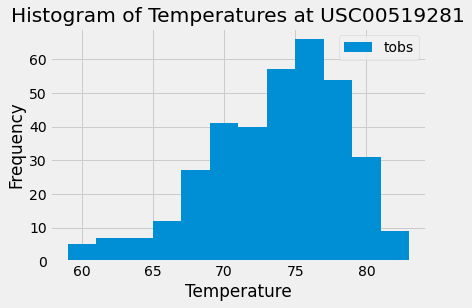

In [30]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station 
# and plot the results as a histogram

# Confirming last date for this station
last_date2 = session.query(func.max(M.date)).filter(M.station == active1).all()

# And calculating one year ago
time_data = last_date2[0][0]
format_data = "%Y-%m-%d"
date = dt.datetime.strptime(time_data, format_data)
year_ago = date-dt.timedelta(days=365)

results = session.query(M.tobs).filter(M.date > year_ago).filter(M.station == active1).all()
temps = [result[0] for result in results]



plt.hist(temps,bins=12, label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.title(f'Histogram of Temperatures at {active1}')

# Close session

In [31]:
# Close Session
session.close()